In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy
import matplotlib.image as mpimg
import itertools
from skimage.feature import hog
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

In [2]:
# load data
cars = glob.glob('./data/vehicles/*/*.png')
noncars = glob.glob('./data/non-vehicles/*/*.png')

car_imgs = list()
noncar_imgs = list()
for car in cars:
  car_imgs.append(plt.imread(car))
  
for noncar in noncars:
  noncar_imgs.append(plt.imread(noncar))
  
car_imgs = np.array(car_imgs)
noncar_imgs = np.array(noncar_imgs)

num_cars = len(car_imgs)
num_noncars = len(noncar_imgs)
print('car num:', num_cars)
print('noncar num:', num_noncars)

car num: 8792
noncar num: 8968


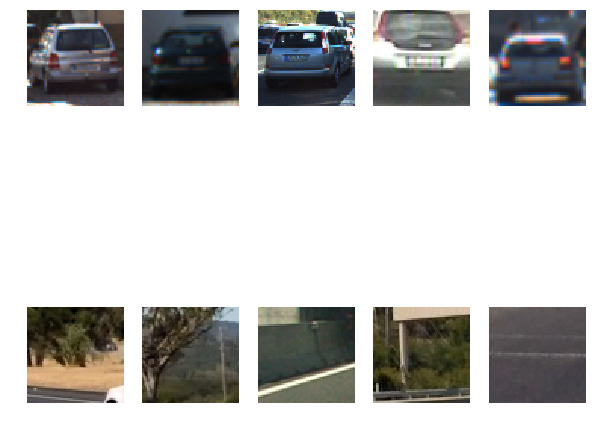

In [3]:
# Plot images
def visualize_imgs(img_lists, rows, cols, axisoff=True, figsize=(10,10)):
  plt.figure()
  fig, axes = plt.subplots(rows, cols, figsize=figsize)
  for i in range(rows):
    for j in range(cols):
      img = img_lists[i][j]
      
      if len(img.shape) == 2:
        axes[i][j].imshow(img, cmap='gray')
      else:
        axes[i][j].imshow(img)
      if axisoff:
        axes[i][j].axis('off')
  #plt.subplots_adjust(wspace=0.1, top=0.5)
  plt.show()
  
img_lists = list()
img_lists.append(car_imgs[np.random.choice(num_cars, 5, replace=False)])
img_lists.append(noncar_imgs[np.random.choice(num_noncars, 5, replace=False)])

visualize_imgs(img_lists, 2, 5)

(8792, 4932)
0.596157


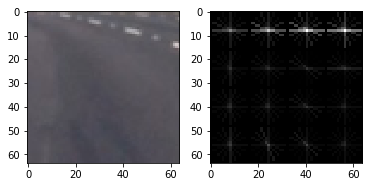

In [4]:
####
# Featrue Extraction
####
# Extract HOG feature
def extract_hog(img, orient, pix_per_cell, cell_per_block, 
                         vis=False, feature_vec=True):
  # Call with two outputs if vis==True
  if vis == True:
    features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                              visualise=vis, feature_vector=feature_vec)
    return features, hog_image
  # Otherwise call with one output
  else:      
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                   visualise=vis, feature_vector=feature_vec)
    return features
  
# Extract binned color feature
def extract_bin_spatial(img, size=(32, 32)):
  features = cv2.resize(img, size).ravel() 
  return features

# Extract color histogram feature
def extract_color_hist(img, nbins=32, bins_range=(0, 1)):
  if len(img.shape) == 2:
    hist_features = np.histogram(img, bins=nbins, range=bins_range)
  else: 
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
  return hist_features


def single_img_features(img, color_space='RGB', 
                       add_hog=True, add_bin_spatial=True, add_color_hist=True,
                       hog_channel=0, orient=9, pix_per_cell=8, cell_per_block=2,
                       spatial_size=(32, 32), 
                       nbins=32, bin_range=(0, 1)):
  feature = np.empty((0))
  if color_space != 'RGB':
    feat_img = cv2.cvtColor(img, getattr(cv2, 'COLOR_RGB2'+color_space))
  else:
    feat_img = np.copy(img)

  if add_hog:
    if color_space == 'GRAY':
      hog_feature = extract_hog(feat_img, orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    elif hog_channel == 'ALL':
      hog_feature = []
      for channel in range(feat_img.shape[2]):
        hog_feature.append(
          extract_hog(feat_img[:,:,channel], orient, 
                      pix_per_cell, cell_per_block, vis=False, feature_vec=True))
      hog_feature = np.ravel(hog_feature)        
    else:
      hog_feature = extract_hog(feat_img[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    feature = np.hstack((feature, hog_feature))
  if add_bin_spatial:
    bin_spatial_feat = extract_bin_spatial(feat_img, spatial_size)
    feature = np.hstack((feature, bin_spatial_feat))
  if add_color_hist:
    color_hist_feat = extract_color_hist(feat_img, nbins, bin_range)
    feature = np.hstack((feature, color_hist_feat))

  return feature


def extract_features(imgs, color_space='RGB', 
                     add_hog=True, add_bin_spatial=True, add_color_hist=True,
                     hog_channel=0, orient=9, pix_per_cell=8, cell_per_block=2,
                     spatial_size=(32, 32), 
                     nbins=32, bin_range=(0, 1)):
  features = list()
  for i in range(len(imgs)):
    feature = np.empty((0))
    img = imgs[i]
    if color_space != 'RGB':
      feat_img = cv2.cvtColor(img, getattr(cv2, 'COLOR_RGB2'+color_space))
    else:
      feat_img = np.copy(img)
      
    if add_hog:
      if color_space == 'GRAY':
        hog_feature = extract_hog(feat_img, orient, 
                                  pix_per_cell, cell_per_block, vis=False, feature_vec=True)
      elif hog_channel == 'ALL':
        hog_feature = []
        for channel in range(feat_img.shape[2]):
          hog_feature.append(
            extract_hog(feat_img[:,:,channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_feature = np.ravel(hog_feature)        
      else:
        hog_feature = extract_hog(feat_img[:,:,hog_channel], orient, 
                                  pix_per_cell, cell_per_block, vis=False, feature_vec=True)
      feature = np.hstack((feature, hog_feature))
    if add_bin_spatial:
      bin_spatial_feat = extract_bin_spatial(feat_img, spatial_size)
      feature = np.hstack((feature, bin_spatial_feat))
    if add_color_hist:
      color_hist_feat = extract_color_hist(feat_img, nbins, bin_range)
      feature = np.hstack((feature, color_hist_feat))

    features.append(feature)
    
  features = np.array(features)
  print(features.shape)
  return features

example_img = noncar_imgs[10]
ft, hog_img = extract_hog(cv2.cvtColor(example_img, cv2.COLOR_RGB2GRAY), 8, 16, 1, vis=True)
plt.figure()
fig, axes = plt.subplots(1,2)
axes[0].imshow(example_img)
axes[1].imshow(hog_img, cmap='gray')

ft = extract_features(car_imgs)
print(np.max(cv2.cvtColor(car_imgs[0], cv2.COLOR_RGB2GRAY)))

In [5]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
  # If x and/or y start/stop positions not defined, set to image size
  if x_start_stop[0] == None: x_start_stop[0] = 0
  if x_start_stop[1] == None: x_start_stop[1] = img.shape[1]
  if y_start_stop[0] == None: y_start_stop[0] = 0
  if y_start_stop[1] == None: y_start_stop[1] = img.shape[0]
  # Compute the span of the region to be searched    
  xspan = x_start_stop[1] - x_start_stop[0]
  yspan = y_start_stop[1] - y_start_stop[0]
  # Compute the number of pixels per step in x/y
  nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
  ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
  # Compute the number of windows in x/y
  nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
  ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
  nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
  ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
  # Initialize a list to append window positions to
  window_list = []
  # Loop through finding x and y window positions
  # Note: you could vectorize this step, but in practice
  # you'll be considering windows one by one with your
  # classifier, so looping makes sense
  for ys in range(ny_windows):
    for xs in range(nx_windows):
      # Calculate window position
      startx = xs*nx_pix_per_step + x_start_stop[0]
      endx = startx + xy_window[0]
      starty = ys*ny_pix_per_step + y_start_stop[0]
      endy = starty + xy_window[1]
      # Append window position to list
      window_list.append(((startx, starty), (endx, endy)))
  # Return the list of windows
  return window_list


def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, 
                   hist_range=(0, 1), orient=9, 
                   pix_per_cell=8, cell_per_block=2, 
                   hog_channel=0, spatial_feat=True, 
                   hist_feat=True, hog_feat=True):
  #1) Create an empty list to receive positive detection windows
  on_windows = []
  #2) Iterate over all windows in the list
  for window in windows:
    #3) Extract the test window from original image
    test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
    #4) Extract features for that window using single_img_features()
    features = single_img_features(test_img, color_space=color_space,
                                   add_hog=hog_feat, add_bin_spatial=spatial_feat, add_color_hist=hist_feat,
                                   hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                   spatial_size=spatial_size, nbins=hist_bins, bin_range=hist_range)
    #5) Scale extracted features to be fed to classifier
    test_features = scaler.transform(np.array(features).reshape(1, -1))
    #6) Predict using your classifier
    prediction = clf.predict(test_features)
    #7) If positive (prediction == 1) then save the window
    if prediction == 1:
      on_windows.append(window)
  #8) Return windows for positive detections
  return on_windows


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
  # Make a copy of the image
  imcopy = np.copy(img)
  # Iterate through the bounding boxes
  for bbox in bboxes:
    # Draw a rectangle given bbox coordinates
    cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
  # Return the image copy with boxes drawn
  return imcopy

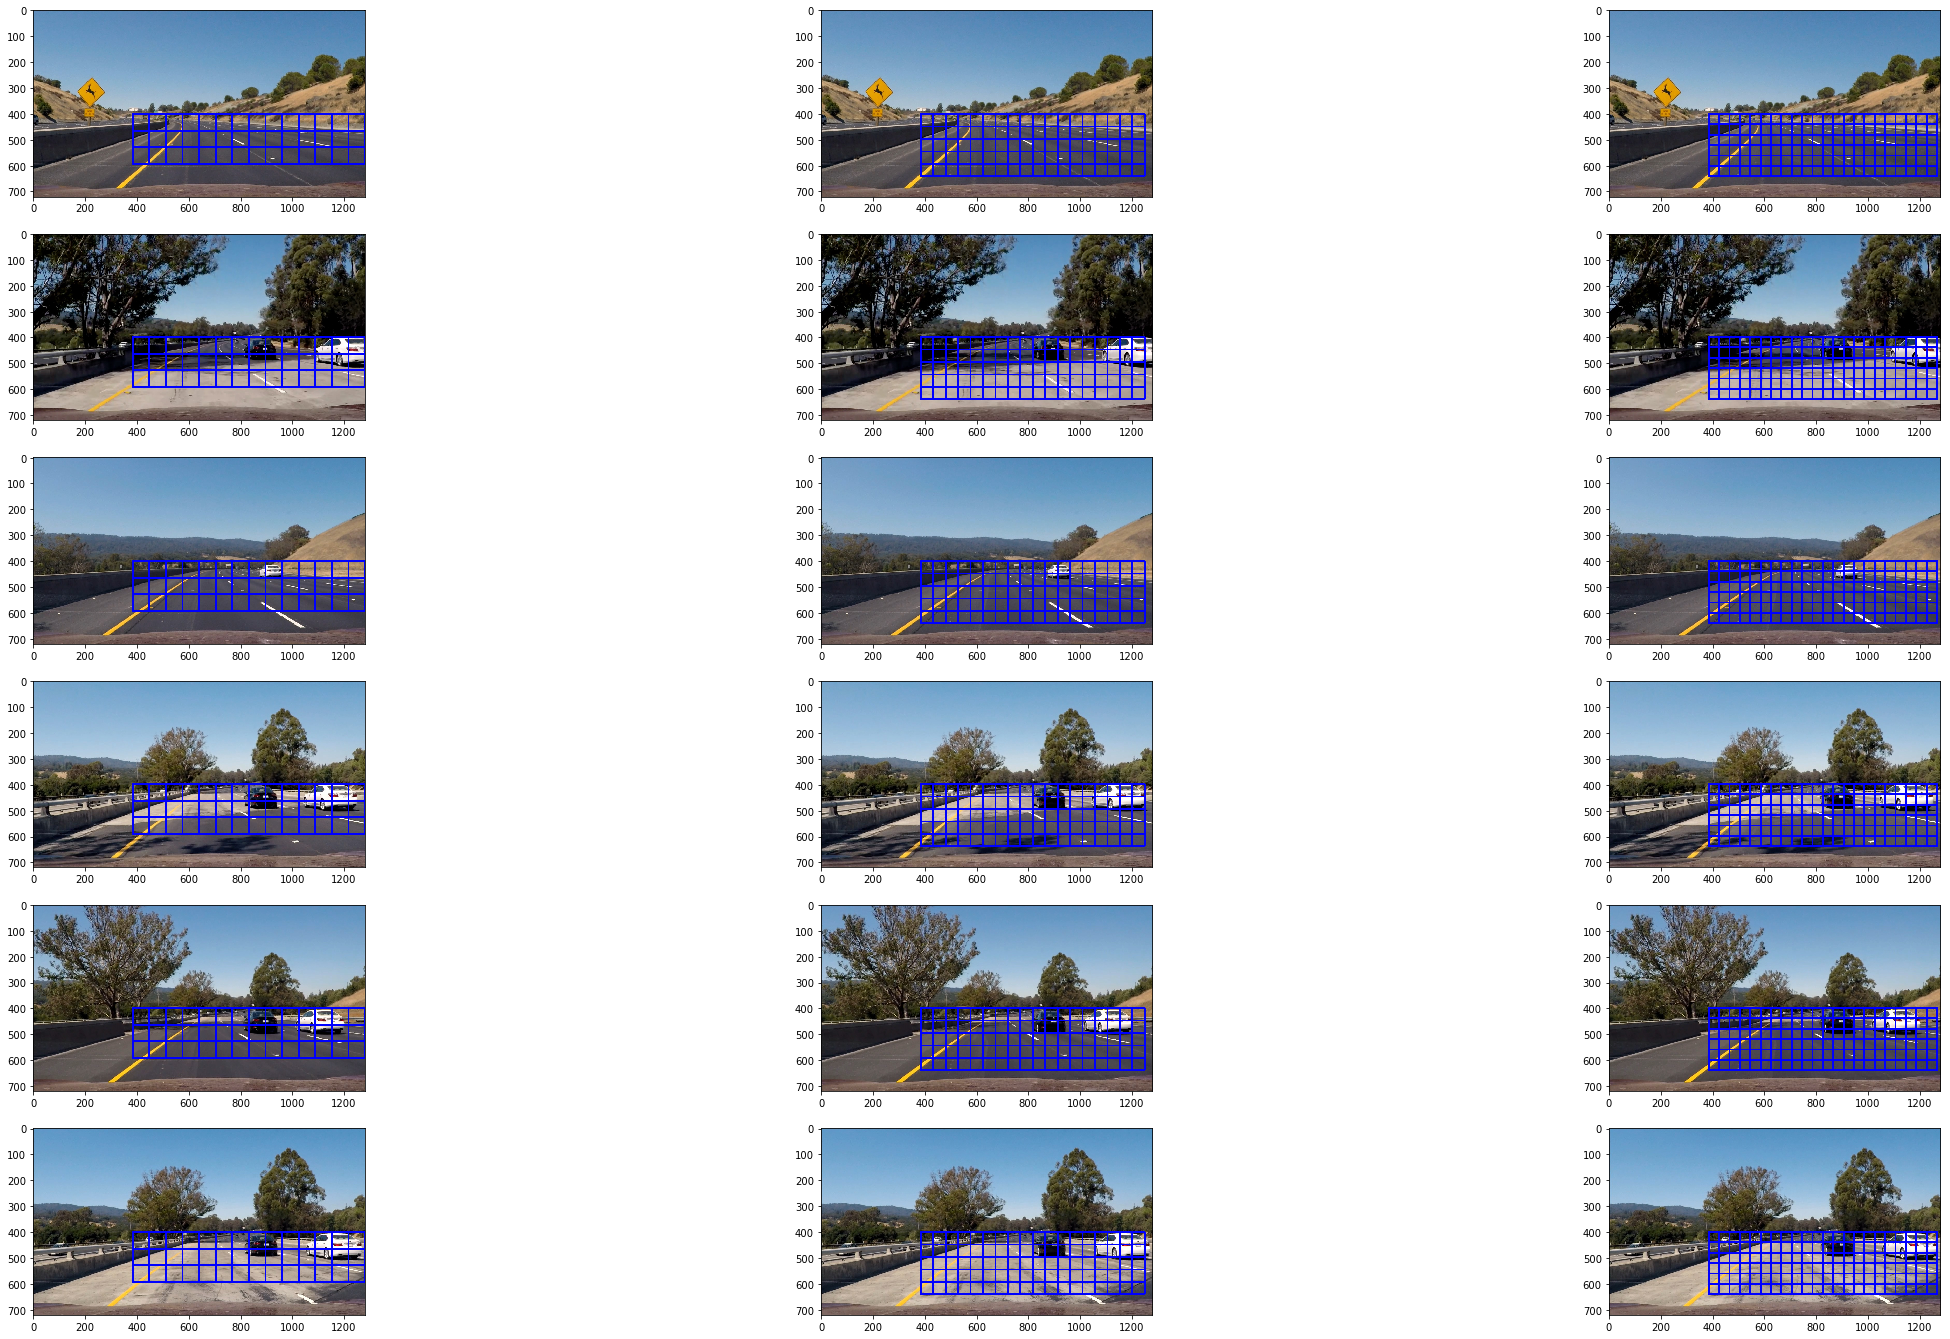

In [6]:
# Play with sliding windows
x_start_stop = [384, 1280]
y_start_stop = [400, 650]
xy_overlap = [0.5, 0.5]
window_sizes = [
  [128, 128],
  [96, 96],
  [80, 80],
]

img_lists = list()
test_imgs = glob.glob('./test_images/*.jpg')
for path in test_imgs:
  test_img = mpimg.imread(path)
  windows1 = slide_window(test_img, x_start_stop, y_start_stop, window_sizes[0], xy_overlap)
  windows2 = slide_window(test_img, x_start_stop, y_start_stop, window_sizes[1], xy_overlap)
  windows3 = slide_window(test_img, x_start_stop, y_start_stop, window_sizes[2], xy_overlap)

  img1 = draw_boxes(test_img, windows1)
  img2 = draw_boxes(test_img, windows2)
  img3 = draw_boxes(test_img, windows3)
  img_lists.append([img1, img2, img3])
    
visualize_imgs(img_lists, len(test_imgs), 3, figsize=(40, 24), axisoff=False) 

In [7]:
# Parameters
color_space = 'GRAY'
add_hog = True
add_bin_spatial = False
add_color_hist = False
hog_channel = 'ALL'
orient = 8
pix_per_cell = 16
cell_per_block = 1
spatial_size = (16, 16)
nbins = 16

In [8]:
# Actually extracting features from data
extended_cars = car_imgs
extended_noncars = noncar_imgs

car_ft = extract_features(extended_cars, color_space=color_space,
                          add_hog=add_hog, add_bin_spatial=add_bin_spatial, add_color_hist=add_color_hist,
                          hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                          spatial_size=spatial_size,
                          nbins=32)
noncar_ft = extract_features(extended_noncars, color_space=color_space,
                          add_hog=add_hog, add_bin_spatial=add_bin_spatial, add_color_hist=add_color_hist,
                          hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                          spatial_size=spatial_size,
                          nbins=32)

X = np.vstack((car_ft, noncar_ft))
y = np.hstack((np.ones(len(car_ft)), np.zeros(len(noncar_ft))))

# Normalize data
scaler = StandardScaler().fit(X)
scaled_X = scaler.transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

nTr, nTrPos = len(y_train), int(np.sum(y_train))
nTe, nTePos = len(y_test), int(np.sum(y_test))
print('Training data: {}. {} cars, {} noncars.'.format(nTr, nTrPos, nTr-nTrPos))
print('Testing data: {}. {} cars, {} noncars.'.format(nTe, nTePos, (nTe-nTePos)))

(8792, 128)
(8968, 128)
Training data: 14208. 7041 cars, 7167 noncars.
Testing data: 3552. 1751 cars, 1801 noncars.


In [9]:
# Train the classifier
svc = svm.SVC()
svc.fit(X_train, y_train)
print('Train Accuracy: {:.4f}'.format(svc.score(X_train, y_train)))
print('Test Accuracy: {:.4f}'.format(svc.score(X_test, y_test)))

Train Accuracy: 0.9963
Test Accuracy: 0.9885


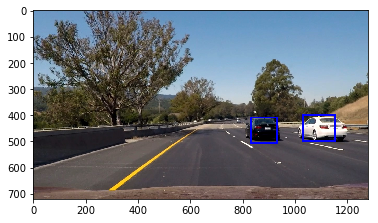

In [10]:
test_img = mpimg.imread('./test_images/test3.jpg')
windows1 = slide_window(test_img, x_start_stop, y_start_stop, window_sizes[0], xy_overlap)
windows2 = slide_window(test_img, x_start_stop, y_start_stop, window_sizes[1], xy_overlap)
windows3 = slide_window(test_img, x_start_stop, y_start_stop, window_sizes[2], xy_overlap)
windows = windows1 + windows2 + windows3

def generate_heatmap(img, bbox_list, threshold=0):
  heatmap = np.zeros_like(img[:,:,0]).astype(np.float)

  # Iterate through list of bboxes
  for box in bbox_list:
    # Add += 1 for all pixels inside each bbox
    # Assuming each "box" takes the form ((x1, y1), (x2, y2))
    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

  heatmap[heatmap <= threshold] = 0
  # Return updated heatmap
  return heatmap

def overlap(box1, box2, threshold=0.25):
  endx = min(box1[1][0], box2[1][0])
  endy = min(box1[1][1], box2[1][1])
  startx = max(box1[0][0], box2[0][0])
  starty = max(box1[0][1], box2[0][1])
  if startx > endx or starty > endy:
    return False
   
  box1_area = (box1[1][0] - box1[0][0]) * (box1[1][1] - box1[0][1])
  box2_area = (box2[1][0] - box2[0][0]) * (box2[1][1] - box2[1][1])
  overlap_area = (endy - starty) * (endx - startx)
  if overlap_area > box1_area * threshold or overlap_area > box2_area * threshold:
    return True
  else:
    return False
  

def group_boxes(boxes):
  box_groups = list()
  if len(boxes) == 0: return box_group
  
  idx = 0
  while len(boxes) > 0:
    idx += 1
    group = list()
    
    sb = boxes.pop(0)  # seed box
    group.append(sb)
    agg_b = [list(t) for t in sb]  # aggregated box
    
    for i in range(3):
      for b in boxes:
        if overlap(agg_b, b, 0.25*(i+1)):
          boxes.remove(b)
          group.append(b)
          agg_b[0][0] = min(agg_b[0][0], b[0][0])
          agg_b[0][1] = min(agg_b[0][1], b[0][1])
          agg_b[1][0] = max(agg_b[1][0], b[1][0])
          agg_b[1][1] = max(agg_b[1][1], b[1][1])
    
    box_groups.append(group)

  return box_groups
    

def get_final_boxes(boxes, threshold=1):
  final_boxes = list()
  if len(boxes) == 0: return final_boxes
  
  box_groups = group_boxes(boxes)
  for group in box_groups:
    if not (len(group) >= threshold): continue
    
    center = np.mean(np.mean(group, axis=1), axis=0)
    # get all x and all y
    allx = np.array(group)[:, :, 0]
    ally = np.array(group)[:, :, 1]
    xdelta = np.std(allx)
    ydelta = np.std(ally)
    
    # calculate the final box
    startx = int(center[0] - xdelta)
    starty = int(center[1] - ydelta)
    endx = int(center[0] + xdelta)
    endy = int(center[1] + ydelta)
    
    final_boxes.append(((startx, starty), (endx, endy)))
  
  return final_boxes


img_lists = list()
test_paths = glob.glob('./test_images/*.jpg')
for path in test_paths:
  if path != './test_images/test6.jpg': continue
  test_img = mpimg.imread(path)
  hot_windows = search_windows(test_img, windows, svc, scaler, color_space=color_space,
                               spatial_size=spatial_size, hist_bins=nbins,
                               orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               hog_channel=hog_channel, spatial_feat=add_bin_spatial,
                               hist_feat=add_color_hist, hog_feat=add_hog)
  hot_win_img = draw_boxes(test_img, hot_windows)
  heat_img = generate_heatmap(test_img, hot_windows)
  
  final_hw = get_final_boxes(hot_windows)
  final_hw_img = draw_boxes(test_img, final_hw)
  
#   box_groups = group_boxes(hot_windows)
#   print('box groups:', len(box_groups))
#   group_img = draw_boxes(test_img, box_groups[0], color=(0, 0, 0))
#   group_img = draw_boxes(group_img, box_groups[1], color=(255, 0, 0))
#   group_img = draw_boxes(group_img, box_groups[2], color=(0, 255, 0))
#   group_img = draw_boxes(group_img, box_groups[3], color=(0, 0, 255))
  
#   plt.figure()
#   plt.imshow(hot_win_img)
  plt.figure()
  plt.imshow(final_hw_img)
  img_lists.append([hot_win_img, heat_img, final_hw_img])

# visualize_imgs(img_lists, len(test_paths), 3, figsize=(20, 12))

In [11]:
last_boxes = deque(maxlen=5)
def process_img(img):
  hot_windows = search_windows(img, windows, svc, scaler, color_space=color_space,
                               spatial_size=spatial_size, hist_bins=nbins,
                               orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               hog_channel=hog_channel, spatial_feat=add_bin_spatial,
                               hist_feat=add_color_hist, hog_feat=add_hog)
  last_boxes.append(hot_windows)
  new_hot_windows = list(itertools.chain.from_iterable(list(last_boxes)))
  final_hw = get_final_boxes(new_hot_windows, 5)
  final_hw_img = draw_boxes(img, final_hw)
  
  return final_hw_img

In [12]:
inpath = './project_video.mp4'
outpath = './project_out.mp4'
last_boxes.clear()
clip = VideoFileClip(inpath)
result = clip.fl_image(process_img)
result.write_videofile(outpath, audio=False)

[MoviePy] >>>> Building video ./project_out.mp4
[MoviePy] Writing video ./project_out.mp4


100%|█████████▉| 1260/1261 [04:29<00:00,  4.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_out.mp4 

